In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
from nfsde.models.CTFP import CTFP
from nfsde.base_sde import Brownian, OU
from nfsde.experiments.synthetic.data import get_data_loaders
from nfsde.modules.sde_gan import SDEGAN
from nfsde.modules.flow_gan import FlowGAN
from nfsde.util import dotdict
import os
# import pytorch_lightning as pl
import torchcde
import torchsde

from torch.distributions import Normal
# %load_ext tensorboard

C:\Users\user\Anaconda3\envs\neuralf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [297]:
args = {
    'd_hidden_dim': 16,
    'flow_layers': 2,
    'hidden_state_dim': -1,
    'w_dim': 2,
    'z_dim': 2,
}
args = dotdict(args)
args.data_dir= 'nfsde/experiments/data/synth'
args['initial_noise_size'] = 5
args['noise_size'] = 3
args['hidden_layers'] = 1
args['hidden_dim'] = 16
args['experiment'] = 'synthetic'
args['data'] = 'ou'
args['batch_size'] = 10
args.model = 'flow-gan'
args.flow_model = 'coupling'
args.time_net = 'TimeFourier'
args.time_hidden_dim = 8
args.activation = 'ReLU'
args.d_hidden_layers = 1
args.init_mult1 = 0.2
args.init_mult2 = 0.2
args.d_model = 'CDE'
args.d_hidden_state_dim = 16
args.optim = 'SGD'

In [114]:
# def get_experiment(args):
#     if args.model == 'sde-gan':
#         return SDEGAN
#     else:
#         return FlowGAN

# model_class = get_experiment(args)


flowpath = {
    'ou': "nfsde/result/download/synthexp/1/ou_flow/checkpoints/last.ckpt",
    'ou2': "nfsde/result/download/synthexp/1/ou2_flow/checkpoints/last.ckpt",
    'gbm': "nfsde/result/download/synthexp/1/gbm_flow/checkpoints/last.ckpt",
    'linear': "nfsde/result/download/synthexp/1/linear_flow/checkpoints/last.ckpt",
    'lorenz': "nfsde/result/download/synthexp/2/version_6986598/checkpoints/last.ckpt",
}
sdepath = {
    'ou': "nfsde/result/download/synthexp/1/ou_sde/checkpoints/last.ckpt",
    'ou2': "nfsde/result/download/synthexp/1/ou2_sde/checkpoints/last.ckpt",
    'gbm': "nfsde/result/download/synthexp/1/gbm_sde/checkpoints/last.ckpt",
    'linear': "nfsde/result/download/synthexp/1/linear_sde/checkpoints/last.ckpt",
    'lorenz': "nfsde/result/download/synthexp/2/version_6986592/checkpoints/last.ckpt",
}

batch_size = 10
datadict = {
'ou': get_data_loaders('ou', batch_size),
'ou2': get_data_loaders('ou2', batch_size),
'gbm': get_data_loaders('gbm', batch_size),
'linear': get_data_loaders('linear', batch_size),
'lorenz':get_data_loaders('lorenz', batch_size),
}

# module = model_class.load_from_checkpoint(checkpoint, data=data)
# dl_test = module.test_dataloader()

C:\Users\user\Anaconda3\envs\neuralf\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
C:\Users\user\Anaconda3\envs\neuralf\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)]

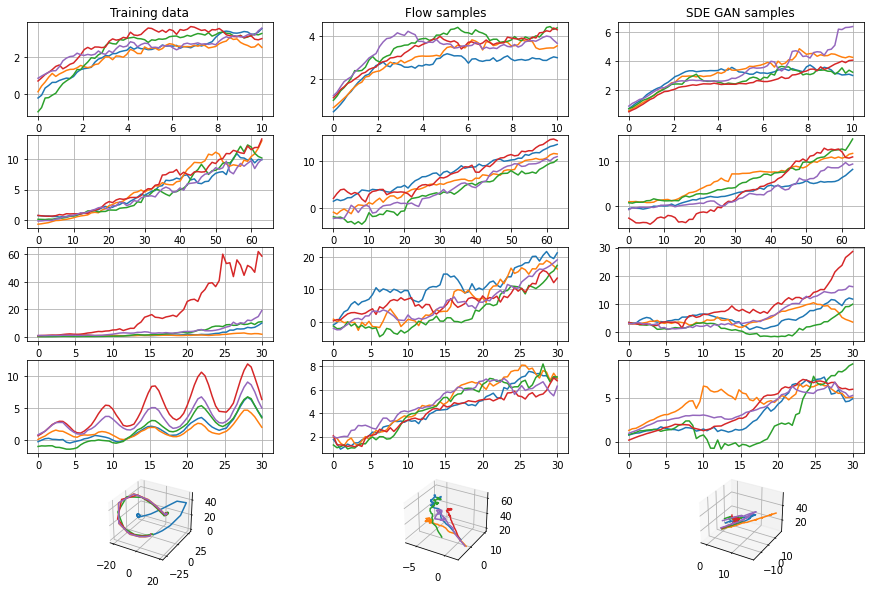

In [121]:
fig = plt.figure(figsize=(15,10))
data_list = ['ou', 'ou2', 'gbm', 'linear', 'lorenz']
rows = len(data_list)
j=0
for data in data_list:
    flow_module = FlowGAN.load_from_checkpoint(flowpath[data], data=datadict[data])
    sde_module = SDEGAN.load_from_checkpoint(sdepath[data], data=datadict[data])
    dl = flow_module.test_dataloader()
    std, mean = dl.dataset.std, dl.dataset.mean
    x, t, y = iter(dl).next()
    sample = flow_module(t, averaged=True) * std + mean
    sample2 = sde_module(t, averaged=True) * std + mean
    
    y_true = y * std + mean
    if data != 'lorenz':
        ax = fig.add_subplot(rows, 3, 3*j + 1)
        for i in range(5):
            ax.plot(t[i], y_true[i])
        if j==0: ax.set_title('Training data')
        # ax.set_xlabel('t', fontsize=16)
        # ax.set_ylabel('x', fontsize=16)
        ax.grid(True)

        ax = fig.add_subplot(rows, 3, 3*j + 2)
        for i in range(5):
            ax.plot(t[i], sample[i])
        if j==0: ax.set_title('Flow samples')
        # ax.set_xlabel('t', fontsize=16)
        # ax.set_ylabel('x', fontsize=16)
        ax.grid(True)

        ax = fig.add_subplot(rows, 3, 3*j + 3)
        for i in range(5):
            ax.plot(t[i], sample2[i])
        if j==0: ax.set_title('SDE GAN samples')
        # ax.set_xlabel('t', fontsize=16)
        # ax.set_ylabel('x', fontsize=16)
        ax.grid(True)
    else:
        ax = fig.add_subplot(rows, 3, 3*j + 1, projection='3d')
        for i in range(5):
            ax.plot(y_true[i,:,0],y_true[i,:, 1],y_true[i,:,2])
        ax.grid(True)
        
        ax = fig.add_subplot(rows, 3, 3*j + 2, projection='3d')
        for i in range(5):
            ax.plot(sample[i,:,0],sample[i,:, 1],sample[i,:,2])
        ax.grid(True)
        
        ax = fig.add_subplot(rows, 3, 3*j + 3, projection='3d')
        for i in range(5):
            ax.plot(sample2[i,:,0],sample2[i,:, 1],sample2[i,:,2])
        ax.grid(True)
    
    j = j+1
    
# plt.savefig('lorenz.png')
# plt.show()

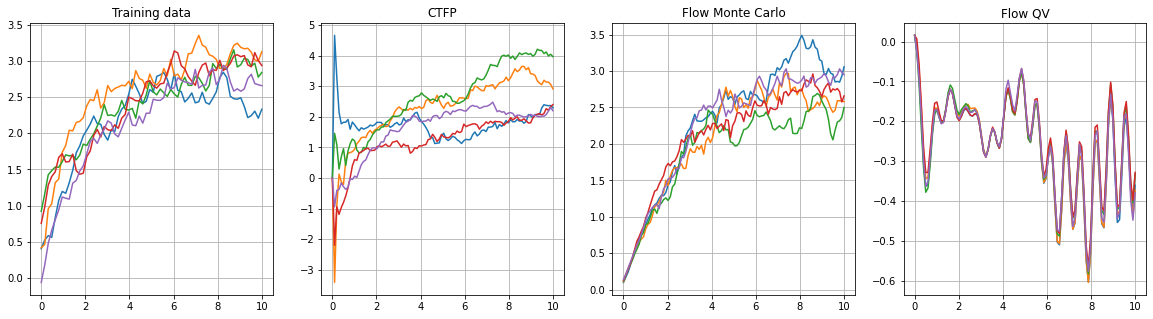

In [108]:
x = np.load('nfsde/result/ctfp-ou/traj.npz')
fig = plt.figure(figsize=(20, 5))
dl = get_data_loaders('ou', batch_size)[3]
_, t, y = iter(dl).next()
std, mean = dl.dataset.std, dl.dataset.mean
y_true = y* std + mean

ax = fig.add_subplot(1, 4, 1)
for i in range(5):
    ax.plot(t[i].squeeze(-1), y_true[i].squeeze(-1))
ax.set_title('Training data')
ax.grid()

ax = fig.add_subplot(1,4,2)
for k in range(5):
    ax.plot(x['t'][k], x['y'][k])
ax.grid(True)
ax.set_title('CTFP')

x = np.load('nfsde/result/mc-ou/traj.npz')
ax = fig.add_subplot(1,4,3)
for k in range(5):
    ax.plot(x['t'][k], x['y'][k])
ax.set_title('Flow Monte Carlo')
ax.grid(True)

x = np.load('nfsde/result/mseqv/traj.npz')
ax = fig.add_subplot(1,4,4)
for k in range(5):
    ax.plot(x['t'][k], x['y'][k])
ax.set_title('Flow QV')
ax.grid(True)